# Лабораторная работа №4 «Определение числовых характеристик выборки»

## Задание 1

In [34]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr
import matplotlib.pyplot as plt


df = pd.read_csv("DataBikes_new.csv")
df_describe = df.select_dtypes(include='number').copy()
display(df_describe)

,Unnamed: 0,Hour,Temperature,Humidity,Wind speed,Rainfall,Snowfall,Rental count,score
0,0,0,-5.2,37,2.2,0.0,0.0,257,56.0
1,1,1,-5.5,38,0.8,0.0,0.0,219,3.0
2,2,2,-6.0,39,1.0,0.0,0.0,162,7.0
3,3,3,-6.2,40,0.9,0.0,0.0,148,8.0
4,4,4,-6.0,36,2.3,0.0,0.0,97,10.0
...,...,...,...,...,...,...,...,...,...
8755,8755,19,4.2,34,2.6,0.0,0.0,644,55.0
8756,8756,20,3.4,37,2.3,0.0,0.0,359,10.0
8757,8757,21,2.6,39,0.3,0.0,0.0,1236,8.0
8758,8758,22,2.1,41,1.0,0.0,0.0,628,8.0


## 2. Статистики температуры по сезонам

In [35]:
grouped = df.groupby('Seasons')['Temperature']

stats = pd.DataFrame({
    'mean': grouped.mean(),
    'median': grouped.median(),
    'mode': grouped.apply(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan),
    'variance': grouped.var(),
    'std': grouped.std(),
    'range': grouped.max() - grouped.min(),
    'IQR': grouped.quantile(0.75) - grouped.quantile(0.25)
})
display(stats)

,mean,median,mode,variance,std,range,IQR
Seasons,,,,,,,
Autumn,14.138821,13.8,10.8,49.589573,7.041986,33.5,11.1
Spring,13.038533,13.3,9.6,43.665630,6.607997,36.0,9.9
Summer,26.574827,26.6,23.4,21.655814,4.653581,23.1,6.7
Winter,-2.567783,-2.2,-1.8,29.877730,5.466052,28.1,7.7


## 3. Замена пропущенных значений в Temperature

In [36]:
# Создаём копию
df_filled = df.copy()

# Группируем по Seasons и Hour, заполняем пропуски средним в группе
df_filled['Temperature'] = df_filled.groupby(['Seasons', 'Hour'])['Temperature'].transform(
    lambda x: x.fillna(x.mean())
)

print("До:", df['Temperature'].describe())
print()
print("После:", df_filled['Temperature'].describe())

До: count    8581.000000
mean       12.878557
std        11.955551
min       -17.800000
25%         3.400000
50%        13.700000
75%        22.500000
max        39.400000
Name: Temperature, dtype: float64

После: count    8760.000000
mean       12.874765
std        11.918847
min       -17.800000
25%         3.500000
50%        13.700000
75%        22.500000
max        39.400000
Name: Temperature, dtype: float64


## 4. Удаление выбросов

In [37]:
df_no_outliers = df_filled.copy()

season_stats = df_no_outliers.groupby('Seasons')['Temperature'].agg(['mean', 'std']).reset_index()

# Слияние со статистиками
df_no_outliers = df_no_outliers.merge(season_stats, on='Seasons')

# Фильтрация: оставить только те, где |T - mean| <= 2*std
df_no_outliers = df_no_outliers[
    np.abs(df_no_outliers['Temperature'] - df_no_outliers['mean']) <= 2 * df_no_outliers['std']
]

# Сравнение средних
print("Исходное среднее:", df_filled['Temperature'].mean())
print("Без выбросов:", df_no_outliers['Temperature'].mean())

Исходное среднее: 12.874764790276942
Без выбросов: 12.962065115192923


## 5. График размаха температуры по месяцам

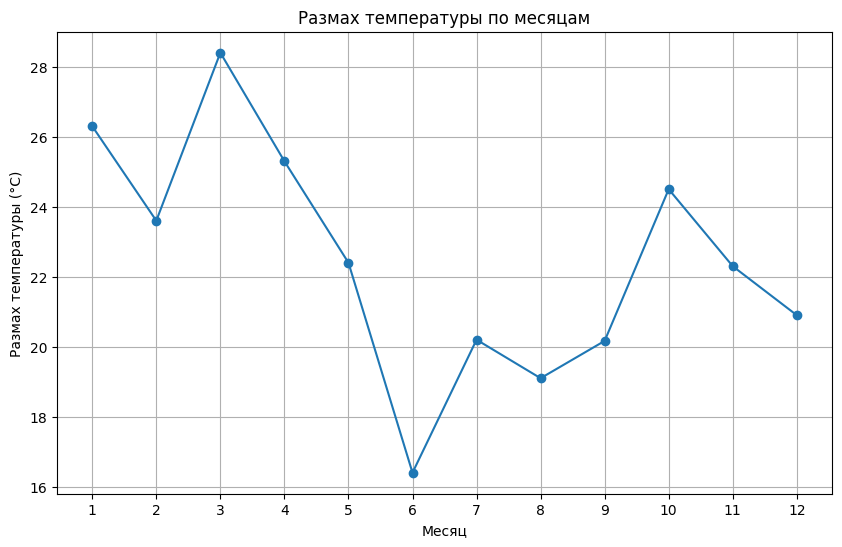

In [38]:
df_plot = df_filled.copy()
df_plot['Date'] = pd.to_datetime(df_plot['Date'], dayfirst=True)
df_plot['Month'] = df_plot['Date'].dt.month

monthly_range = df_plot.groupby('Month')['Temperature'].apply(lambda x: x.max() - x.min())

plt.figure(figsize=(10,6))
plt.plot(monthly_range.index, monthly_range.values, marker='o')
plt.title('Размах температуры по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Размах температуры (°C)')
plt.xticks(range(1,13))
plt.grid(True)
plt.show()

## 6. Сколько дней работа проката по оценкам была выше среднего.

In [39]:
df_z = df_filled.copy()
df_z['z_score'] = df_z.groupby('score_type')['score'].transform(
    lambda x: (x - x.mean()) / x.std()
)

df_z['Date'] = pd.to_datetime(df_z['Date'], dayfirst=True)

daily_z = df_z.groupby('Date')['z_score'].mean()

above_avg_days = (daily_z > 0).sum()
print(f"Дней с оценкой выше среднего: {above_avg_days}")

Дней с оценкой выше среднего: 182


## 7. Наличие линейной зависимости между температурой и числом арендованных велосипедов

In [42]:
r_all, p_all = pearsonr(df_filled['Temperature'], df_filled['Rental count'])
print(f"Весь год: r = {r_all:.3f}")

for season in df_filled['Seasons'].unique():
    sub = df_filled[df_filled['Seasons'] == season]
    r, p = pearsonr(sub['Temperature'], sub['Rental count'])
    print(f"{season}: r = {r:.3f}")
    
df_filled['Date'] = pd.to_datetime(df_filled['Date'], dayfirst=True)
df_filled['Month'] = df_filled['Date'].dt.month
for month in sorted(df_filled['Month'].unique()):
    sub = df_filled[df_filled['Month'] == month]
    r, p = pearsonr(sub['Temperature'], sub['Rental count'])
    print(f"Месяц {month}: r = {r:.3f}")

Весь год: r = 0.454
Winter: r = 0.302
Spring: r = 0.468
Summer: r = 0.133
Autumn: r = 0.258
Месяц 1: r = 0.299
Месяц 2: r = 0.405
Месяц 3: r = 0.430
Месяц 4: r = 0.508
Месяц 5: r = 0.382
Месяц 6: r = 0.383
Месяц 7: r = 0.251
Месяц 8: r = 0.166
Месяц 9: r = 0.397
Месяц 10: r = 0.213
Месяц 11: r = 0.116
Месяц 12: r = 0.177


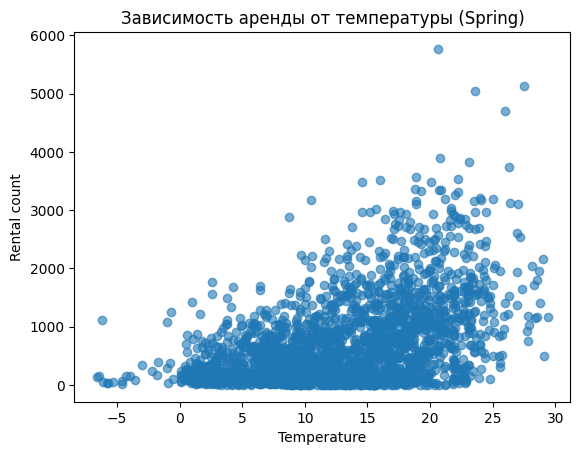

In [45]:
best_group = "Spring"
data = df_filled[df_filled['Seasons'] == best_group]

plt.scatter(data['Temperature'], data['Rental count'], alpha=0.6)
plt.title(f'Зависимость аренды от температуры ({best_group})')
plt.xlabel('Temperature')
plt.ylabel('Rental count')
plt.show()